In [1]:
#Torch Modules
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import VOCDetection
from torchvision import ops
import torch.utils as tu
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

#Other modules
import os, random
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import time
import io

#Image processing modules
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import Utils.utils as utils
from Utils.config_loader import ConfigLoader
from lib.Loaders.base_dataset import BaseDataset
from Utils.logger_utils import TrainingLogger
from Utils.train_utils import *

In [2]:
#from lib.Model.AnchorGen import AnchorGenerator
#from lib.Model.backbones.vgg16 import VGG16_BACKBONE
#from lib.Model.rpn_utils.rpn import RegionProposalNetwork
#from lib.Model.rpn_utils.rpn_proposal_gen import RPNProposalGenerator
#from lib.Model.roi_utils.roi import ROINetwork
#from Model.one_stage_detector import OneStageDetector
from lib.Model.faster_rcnn_detector import FRCNNDetector

In [3]:
config = ConfigLoader("Configs/custom_sample.yaml")

In [4]:
#"cuda:1" if torch.cuda.is_available() else 
device = torch.device("cuda:0")

In [5]:
collate = lambda batch: list(zip(*batch))

In [6]:
start_ = time.time()
train_loader = getDataLoader(device, config, split="train", collate=collate)
val_loader = getDataLoader(device, config, split="validation",collate=collate)
duration = time.time() - start_
print(str(datetime.timedelta(seconds = duration)))

0:01:35.096294


In [7]:
config.get("IMAGE_MEAN")

tensor([0.6038, 0.5528, 0.5071])

In [8]:
config.get("IMAGE_STD")

tensor([0.2331, 0.2438, 0.2513])

In [9]:
model = FRCNNDetector(config)


Loading pretrained weights...
Weights loaded from data/pretrained/vgg16/vgg16-397923af.pth


In [ ]:
model = model.to(device)
model

In [ ]:
len(train_loader)

In [ ]:
#Defining Optimizer
if config.get("OPT_TYPE") == "ADAM":
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config.get("L_RATE"), 
        weight_decay=config.get('WEIGHT_DECAY')
    )
else:
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config.get("L_RATE"), 
        momentum=config.get('MOMENTUM'), 
        weight_decay=config.get('W_DECAY')
    )
#Define Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=config.get('STEP_SIZE'), 
    gamma=config.get('GAMMA')
)

In [ ]:
logger = TrainingLogger(config)

In [ ]:
start_ = time.time()
    
    
for epoch in range(0, config.get("EPOCHS")):
    total_loss, losses, duration = train_epoch(model, optimizer, train_loader, device, debug=False)
        
    scheduler.step()
        
    eval_metrics = evalEpoch(epoch+1, model, val_loader,config, device)
    
    logger.update(total_loss, epoch+1, duration, model, optimizer, eval_metrics, losses)
    logger.summarize()

duration = time.time() - start_
    
print(f"Model Finished Training: {str(datetime.timedelta(seconds = duration))}", flush=True)

In [ ]:
for img_batch, targets_batch in train_loader:
    #img_data = [img.to(device) for img in img_batch]
    img_data = img_batch.to(device)
    targets_data = {k:v.to(device) for k,v in targets_batch.items()}
    #targets_data = [{k:v.to(device) for k,v in target.items()} for target in targets_batch]
    break

In [ ]:
start_ = time.time()
loss_dict, roi_out = model(img_data, targets_data)
print(time.time() - start_)

In [13]:
loss_dict

{'rpn_cls_loss': tensor(0.6932, device='cuda:1', grad_fn=<MulBackward0>),
 'rpn_bbox_loss': tensor(1.5493, device='cuda:1', grad_fn=<MulBackward0>),
 'roi_bbox_loss': tensor(6.3571, device='cuda:1', grad_fn=<SmoothL1LossBackward0>),
 'roi_cls_loss': tensor(0.7740, device='cuda:1', grad_fn=<NllLossBackward0>)}

In [14]:
roi_out['gt_boxes']

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         ...,
         [ -4.0686,   4.6796,  -6.6385, -14.7205],
         [ -0.2959,  -0.9867,  -6.6075, -20.0269],
         [ -3.8566,   0.5626,  -8.7777, -23.4363]]], device='cuda:1',
       grad_fn=<DivBackward0>)

# Predefined Faster RCNN

In [9]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def getFasterRCNN(aspect_sizes, aspect_ratios, num_classes):
    #Defining backbone
    backbone = torchvision.models.vgg16(weights="DEFAULT").features
    backbone.out_channels = 512
    #Defining Anchor Generator
    anchorGenerator = AnchorGenerator(sizes=aspect_sizes, aspect_ratios=aspect_ratios)
    
    model = FasterRCNN(backbone, rpn_anchor_generator=anchorGenerator, num_classes=num_classes)
    
    return model

In [10]:
saved = torch.load('Saved_Models/best_model.pt')

In [11]:
saved_settings = saved['config']

In [58]:
model = getFasterRCNN((saved_settings['ANCHOR_SCALES'],), (saved_settings['ANCHOR_RATIOS'],), saved_settings['NUM_CLASSES'])

In [59]:
model = model.to(device)
model.load_state_dict(saved['model_dict'])
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [74]:
config.setDict(saved_settings)
test_dataset = BaseDataset(config, split='test',pad=False)
collate = lambda batch: list(zip(*batch))
test_loader = torch.utils.data.DataLoader(test_dataset.getDataset(), batch_size=1, shuffle=False, collate_fn=collate)

In [75]:
for img_batch, targets_batch in test_loader:
    img_data = [img.to(device) for img in img_batch]
    #img_data = img_batch.to(device)
    #targets_data = {k:v.to(device) for k,v in targets_batch.items()}
    targets_data = [{k:v.to(device) for k,v in target.items()} for target in targets_batch]
    break

In [76]:
pred_ = model(img_data)

In [77]:
pred_[0]

{'boxes': tensor([[236.9492, 462.3669, 293.8700, 475.3947],
         [ 52.2366, 309.6043, 108.9209, 323.0888],
         [376.6295, 462.3063, 430.7997, 476.3028],
         [152.1955, 463.9152, 196.5656, 477.1270],
         [362.7605, 325.3485, 414.7076, 338.4527],
         [108.3802, 464.6878, 145.2446, 478.5793],
         [207.0442, 325.2758, 262.5128, 338.6461],
         [175.4243, 365.4416, 219.8343, 378.5939],
         [203.2311, 461.7466, 231.6166, 474.4431],
         [ 54.3936, 425.1639, 143.1215, 438.7686],
         [244.3141, 421.9687, 315.2499, 436.2892],
         [176.7492, 305.7685, 235.2802, 320.3159],
         [328.9076, 421.7793, 435.2660, 438.8308],
         [357.1063, 364.1082, 417.5889, 378.1048],
         [165.5079, 423.7352, 228.9382, 436.0564],
         [213.3349, 402.5516, 281.7944, 416.2484],
         [226.4125, 364.1847, 265.2377, 377.2654],
         [ 72.6951, 465.6951, 103.2141, 478.4988],
         [252.4640, 382.4455, 282.4197, 396.1163],
         [366.2216, 40

41


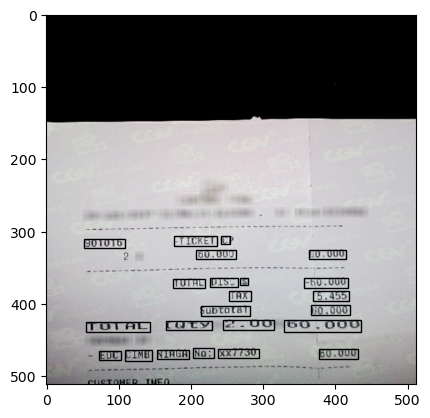

In [84]:
fig, ax = plt.subplots()

img = img_data[0].permute(1,2,0).cpu().numpy()
w,h = 512,512
#new_img = Image.new('RGB',(w,h))
#new_img.paste(img, (0,0))
#new_img.paste(img, (w,0))

ax.imshow(img)

data = pred_[0]
print(len(data['boxes']))
for index, box in enumerate(data['boxes'].detach().cpu().numpy()):
    if data['scores'][index].detach().cpu().numpy() > 0.9:
        x1,y1,x3,y3 = box
        rect = patches.Rectangle((x1,y1), (x3-x1), (y3-y1), fill=None, ec=None, fc=None)
        ax.add_patch(rect)
    

plt.show()

In [79]:
targets_data[0]

{'boxes': tensor([[ 49.7778, 309.7284, 109.0370, 325.5309],
         [173.0370, 304.9876, 237.0370, 320.7901],
         [239.4074, 304.9876, 263.1111, 320.7901],
         [106.6667, 328.6913, 118.5185, 342.9136],
         [206.2222, 323.9506, 265.4815, 339.7531],
         [360.2963, 323.9506, 417.1852, 339.7531],
         [173.0370, 363.4568, 222.8148, 379.2592],
         [222.8148, 363.4568, 266.6667, 376.8889],
         [267.8518, 363.4568, 282.0741, 376.0988],
         [352.0000, 363.4568, 419.5555, 377.6790],
         [251.2593, 380.8395, 284.4445, 396.6420],
         [369.7778, 382.4197, 419.5555, 398.2222],
         [208.5926, 401.3827, 282.0741, 417.1852],
         [362.6667, 401.3827, 421.9259, 418.7654],
         [ 52.1481, 423.5062, 144.5926, 439.3087],
         [331.8518, 420.3457, 436.1482, 438.5185],
         [161.1852, 420.3457, 227.5556, 438.5185],
         [245.3333, 421.1358, 315.2592, 436.1482],
         [ 71.1111, 463.0124, 104.2963, 480.3951],
         [106.6667, 46

In [80]:
from Utils.eval import evaluate

In [81]:
evaluate(model, test_loader, device=device)

{'map': tensor(0.4665),
 'map_50': tensor(0.7953),
 'map_75': tensor(0.4994),
 'map_small': tensor(0.4038),
 'map_medium': tensor(0.5923),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0318),
 'mar_10': tensor(0.2867),
 'mar_100': tensor(0.5354),
 'mar_small': tensor(0.4972),
 'mar_medium': tensor(0.6934),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}